In [101]:
import copy
import pathlib
import sys

import asdf
import astropy.table
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import ebtelplusplus
import eispac
import sunpy.map

from astropy.coordinates import SkyCoord
from ebtelplusplus.models import HeatingModel, TriangularHeatingEvent, SolverModel
from sunpy.coordinates import get_horizons_coord, propagate_with_solar_surface, Helioprojective
from sunpy.net import Fido, attrs as a
from sunkit_image.time_lag import cross_correlation, get_lags
from synthesizAR.instruments.sdo import aia_kernel_quick

sys.path.append('../scripts/')
import colormaps

# Figures for AGU 2024 Poster

Each section lays out a different figure for my AGU 2024 poster on heating frequency in ARs as a function of age.

Set some needed paths and define any needed functions

In [2]:
data_dir = pathlib.Path('../../../talks/loops-workshop-2024-talk/data/')
figure_dir = pathlib.Path('../src/figures/')

First, load the table of AR observations.

In [3]:
ar_table = astropy.table.QTable.read(data_dir / 'tables' / 'mason_ars_region_1.asdf')

In [4]:
ar_table

<QTable length=3>
NOAA AR ...           XRT file          
        ...                             
 int64  ...            str28            
------- ... ----------------------------
  11944 ...                             
  11967 ... L1_XRT20140203_110221.2.fits
  11990 ... L1_XRT20140302_000009.0.fits

Then, load in the AIA and EIS cutouts.

In [5]:
channel_list = ['94','131','171','193','211','335']
aia_cutouts = []
for row in ar_table:
    _md = {}
    for channel in channel_list:
        files = sorted((data_dir / f'noaa_{row["NOAA AR"]}' / 'AIA' / 'level_2').glob(f'aia.lev2_euv_12s.*.{channel}.image.fits'))
        # This loads the image near the midpoint of the observing period
        _md[channel] = sunpy.map.Map(files[len(files)//2])
    aia_cutouts.append(_md)

In [6]:
eis_maps_fe12 = sunpy.map.Map(
    [sorted((data_dir / f'noaa_{r["NOAA AR"]}' / 'EIS' / 'level_2.5').glob('eis_*.fe_12_195_119.2c-0.int.fits'))
     for r in ar_table]
)
eis_maps_fe16 = sunpy.map.Map(
    [sorted((data_dir / f'noaa_{r["NOAA AR"]}' / 'EIS' / 'level_2.5').glob('eis_*.fe_16_262_984.1c-0.int.fits'))
     for r in ar_table]
)

Load in the derived data products. First, the time lags.

In [92]:
max_cc_threshold = 0.25
tl_maps_aia = []
tl_maps_eis = []
cc_maps_aia = []
cc_maps_eis = []
for row in ar_table:
    # Time lags
    tl_dir = data_dir / f'noaa_{row["NOAA AR"]}' / 'diagnostics' / 'time_lag'
    cc_dir = data_dir / f'noaa_{row["NOAA AR"]}' / 'diagnostics' / 'max_cc'
    # AIA FOV
    cc_maps = sunpy.map.Map(sorted(cc_dir.glob(f'maxcc_noaa{row["NOAA AR"]}_fovAIA_*.fits')))
    cc_maps_aia.append({f'{m.meta["chan_a"]}_{m.meta["chan_b"]}': m for m in cc_maps})
    tl_maps = sunpy.map.Map(sorted(tl_dir.glob(f'timelag_noaa{row["NOAA AR"]}_fovAIA_*.fits')))
    for mcc,mtl in zip(cc_maps,tl_maps):
        mtl.mask = mcc.data < max_cc_threshold 
    tl_maps_aia.append({f'{m.meta["chan_a"]}_{m.meta["chan_b"]}': m for m in tl_maps})
    # EIS FOV    
    cc_maps = sunpy.map.Map(sorted(cc_dir.glob(f'maxcc_noaa{row["NOAA AR"]}_fovEIS_*.fits')))
    cc_maps_eis.append({f'{m.meta["chan_a"]}_{m.meta["chan_b"]}': m for m in cc_maps})
    tl_maps = sunpy.map.Map(sorted(tl_dir.glob(f'timelag_noaa{row["NOAA AR"]}_fovEIS_*.fits')))
    for mcc,mtl in zip(cc_maps,tl_maps):
        mtl.mask = mcc.data < max_cc_threshold 
    tl_maps_eis.append({f'{m.meta["chan_a"]}_{m.meta["chan_b"]}': m for m in tl_maps})

Then the EM slope maps.

**TODO: Compute the EIS EM slopes**

In [247]:
em_slopes_eis = []
em_slopes_aia = []
em_slopes_aia_eis_fov = []
for row in ar_table:
    dem_dir = data_dir / f'noaa_{row["NOAA AR"]}' / 'diagnostics' / 'dem'
    with asdf.open(dem_dir / f'emslope_noaa{row["NOAA AR"]}_eis.asdf', lazy_load=False, memmap=False) as af:
        sm = af['slope_map']
        em_slopes_eis.append(sm)
    with asdf.open(dem_dir / f'emslope_noaa{row["NOAA AR"]}_fovAIA.asdf', lazy_load=False, memmap=False) as af:
        sm = af['slope_map']
        em_slopes_aia.append(sm)
    with asdf.open(dem_dir / f'emslope_noaa{row["NOAA AR"]}_fovEIS.asdf', lazy_load=False, memmap=False) as af:
        sm = af['slope_map']
        em_slopes_aia_eis_fov.append(sm)

## AIA Context Images

In [19]:
time_query = a.AttrOr(
    [a.Time(r['Date start'],end=r['Date end'],near=m.date_average) for r,m in zip(ar_table, eis_maps_fe12)]
)
q = Fido.search(time_query, a.Instrument.aia,a.Wavelength(171*u.AA))

# files = Fido.fetch(q, path='../data/{instrument}')
files = sorted((data_dir / 'full_disk_context').glob('aia.lev1.171A_*.fits'))
aia_maps_fd = sunpy.map.Map(files)

In [24]:
observer_locs = [get_horizons_coord('SDO', time=r['Date mid']) for r in ar_table]

2024-12-06 18:03:56 - sunpy - INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395)


INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]


2024-12-06 18:03:57 - sunpy - INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395)


INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]


2024-12-06 18:03:58 - sunpy - INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395)


INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]


2024-12-09 02:05:47 - sunpy - INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395)


INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]


2024-12-09 02:05:48 - sunpy - INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395)


INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]


2024-12-09 02:05:50 - sunpy - INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395)


INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]


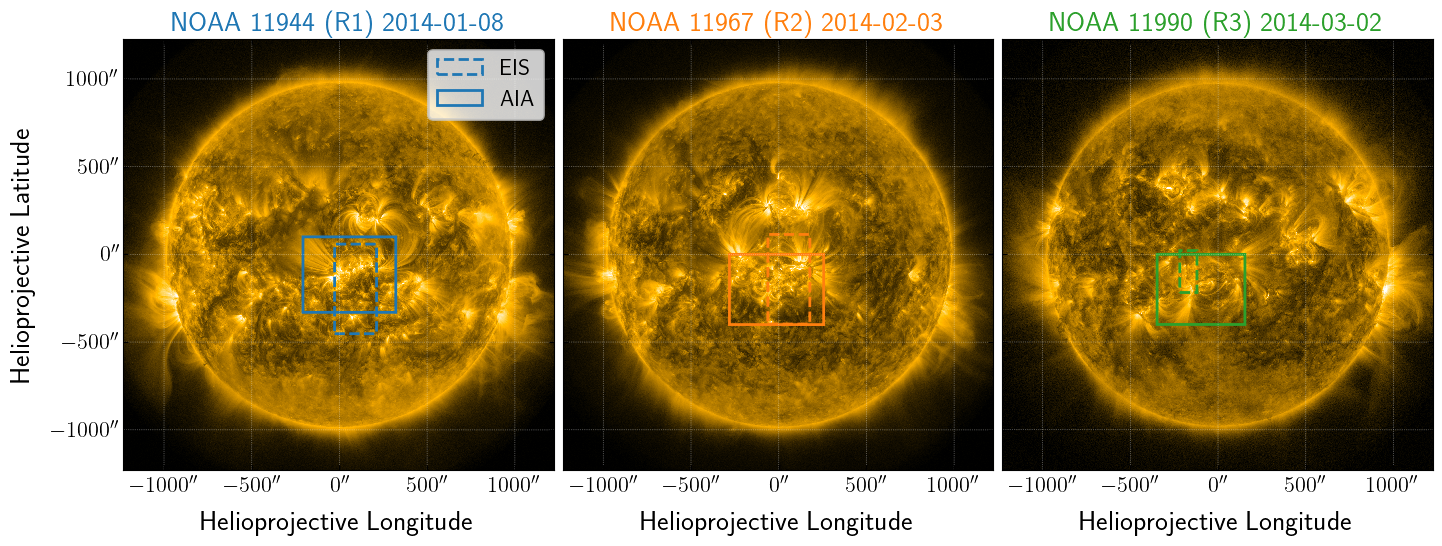

In [239]:
fig = plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*1.1,
                          plt.rcParams['figure.figsize'][1]*1.1))
for i,(row,am,ac,em) in enumerate(zip(ar_table,aia_maps_fd,aia_cutouts,eis_maps_fe12)):
    ax = fig.add_subplot(1,3,i+1,projection=am)
    am.plot(axes=ax, clip_interval=(1,99.99)*u.percent)
    # EIS FOV
    with propagate_with_solar_surface():
       eis_blc = em.bottom_left_coord.transform_to(am.coordinate_frame)
       eis_trc = em.top_right_coord.transform_to(am.coordinate_frame)
       am.draw_quadrangle(eis_blc,
                          top_right=eis_trc,
                          edgecolor=f'C{i}',
                          ls='--',
                          label='EIS')
    # AIA FOV
    frame = Helioprojective(observer=get_horizons_coord('SDO', time=row['Date mid']))
    blc = SkyCoord(*row['bottom left'], frame=frame)
    trc = SkyCoord(*row['top right'], frame=frame)
    with propagate_with_solar_surface():
        am.draw_quadrangle(
            blc.transform_to(am.coordinate_frame),
            top_right=trc.transform_to(am.coordinate_frame),
            edgecolor=f'C{i}',
            ls='-',
            label='AIA',
        )
    ax.coords[1].set_auto_axislabel(False)
    ax.label_outer()
    if i > 0:
        ax.coords[1].set_ticklabel_visible(False)
    if i == 0:
        ax.legend(frameon=True)
    title_date = am.date.datetime
    ax.set_title(f'NOAA {row["NOAA AR"]} (R{i+1}) {title_date.strftime("%Y-%m-%d")}', color=f'C{i}')
    ax.coords[0].set_axislabel('Helioprojective Longitude')
    ax.coords[1].set_axislabel('Helioprojective Latitude')
plt.subplots_adjust(wspace=0.02)
fig.savefig(figure_dir / 'aia_context.pgf')

## AIA Active Region

In [149]:
hw_ratio = sum([ac['171'].data.shape[0] for ac in aia_cutouts]) / (len(channel_list) * aia_cutouts[-1]['171'].data.shape[1])

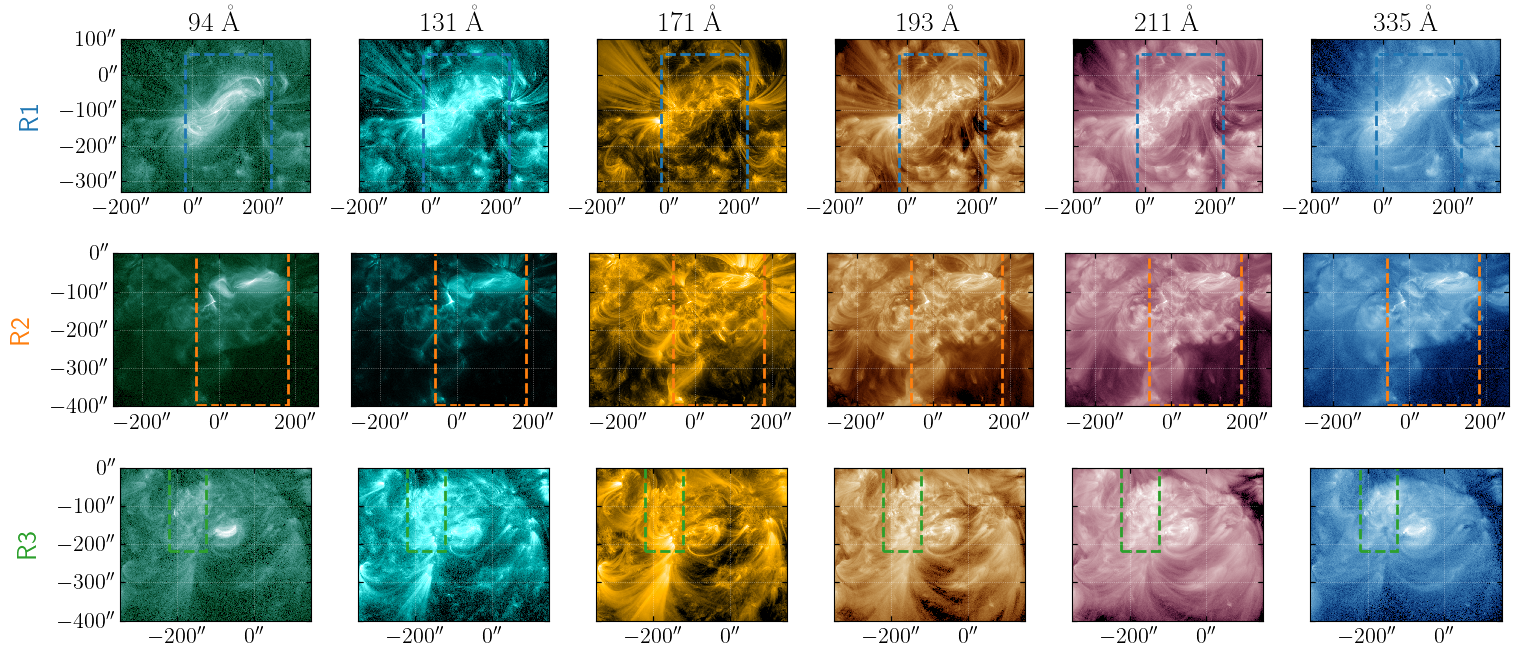

In [167]:
fig = plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*1.2,
                          plt.rcParams['figure.figsize'][0]*hw_ratio*1.2))
for i, (row,em) in enumerate(zip(ar_table,eis_maps_fe12)):
    for j,key in enumerate(channel_list):
        _m = aia_cutouts[i][key]
        ax = fig.add_subplot(len(aia_cutouts),len(aia_cutouts[i]),i*len(channel_list)+j+1,projection=_m)
        _m.plot(axes=ax, annotate=False, clip_interval=(1,99.99)*u.percent)
        # EIS FOV
        with propagate_with_solar_surface():
            eis_blc = em.bottom_left_coord.transform_to(_m.coordinate_frame)
            eis_trc = em.top_right_coord.transform_to(_m.coordinate_frame)
            am.draw_quadrangle(eis_blc,
                               top_right=eis_trc,
                               edgecolor=f'C{i}',
                               ls='--',
                               lw=2,
                               label='EIS')
        # Ticks
        ax.coords[0].set_ticks(number=3)
        # Labeling
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        if j > 0:
            ax.coords[1].set_ticklabel_visible(False)
        else:
            ax.coords[1].set_axislabel(f'R{i+1}', color=f'C{i}')
        if i == 0:
            ax.set_title(f'{_m.wavelength:latex_inline}')
plt.subplots_adjust(hspace=0.4, wspace=0.)
fig.savefig(figure_dir / 'aia_cutouts.pgf')

## EIS Active Region

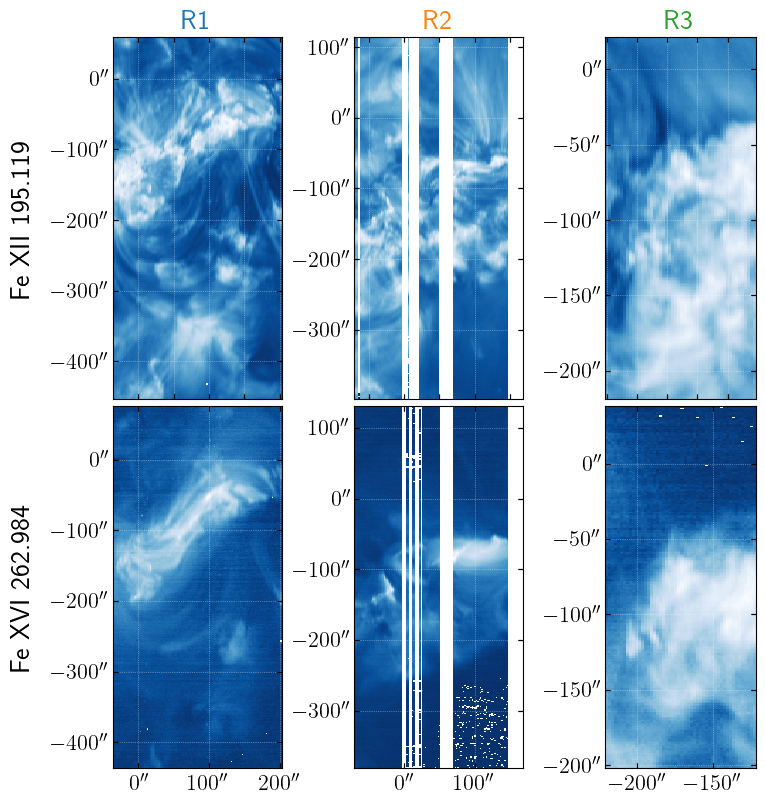

In [76]:
fig = plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*0.575,
                          plt.rcParams['figure.figsize'][1]))
for i,row in enumerate(ar_table):
    # Fe 12
    _m = eis_maps_fe12[i]
    _m.mask = _m.data == 0.0
    ax = fig.add_subplot(2,len(ar_table),i+1,projection=_m)
    _m.plot(axes=ax,annotate=False)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[0].set_auto_axislabel(False)
    ax.coords[1].set_auto_axislabel(False)
    ax.set_title(f'R{i+1}', color=f'C{i}')
    if i == 0:
        ax.coords[1].set_axislabel(_m.meta['line_id'])
    # Fe 15
    _m = eis_maps_fe16[i]
    _m.mask = _m.data == 0.0
    ax = fig.add_subplot(2,len(ar_table),i+4,projection=_m)
    _m.plot(axes=ax,annotate=False)
    ax.coords[0].set_ticks(number=3)
    ax.coords[0].set_auto_axislabel(False)
    ax.coords[1].set_auto_axislabel(False)
    if i == 0:
        ax.coords[1].set_axislabel(_m.meta['line_id'])
plt.subplots_adjust(hspace=0.02)
fig.savefig(figure_dir / 'eis_rasters.pgf')

## Masking Flaring Regions

### Simulation Example

Run an EBTEL simulation for a flare and nanoflare event and plot the temperature and intensity evolution as well as the cross-correlation curves for several 131 channel pairs.

In [85]:
solver = SolverModel(
    use_adaptive_solver=False,
    tau=0.1*u.s,
)

In [86]:
nanoflare_heating = HeatingModel(
    partition=1,
    events=[TriangularHeatingEvent(100*u.s, 200*u.s, 0.02*u.Unit('erg cm-3 s-1'))]
)
flare_heating = HeatingModel(
    partition=1,
    events=[TriangularHeatingEvent(100*u.s, 200*u.s, 1*u.Unit('erg cm-3 s-1'))]
)

In [87]:
results_nanoflare = ebtelplusplus.run(
    5e3*u.s,
    40*u.Mm,
    heating=nanoflare_heating,
    solver=solver,
)
results_flare = ebtelplusplus.run(
    5e3*u.s,
    40*u.Mm,
    heating=flare_heating,
    solver=solver,
)

In [88]:
def compute_ebtel_aia_cross_correlation(ebtel_result, channel_a, channel_b):
    lags = get_lags(ebtel_result.time)
    intensity_a = aia_kernel_quick(channel_a,
                                   ebtel_result.electron_temperature,
                                   ebtel_result.density)
    intensity_b = aia_kernel_quick(channel_b,
                                   ebtel_result.electron_temperature,
                                   ebtel_result.density)
    return cross_correlation(intensity_a, intensity_b, lags)

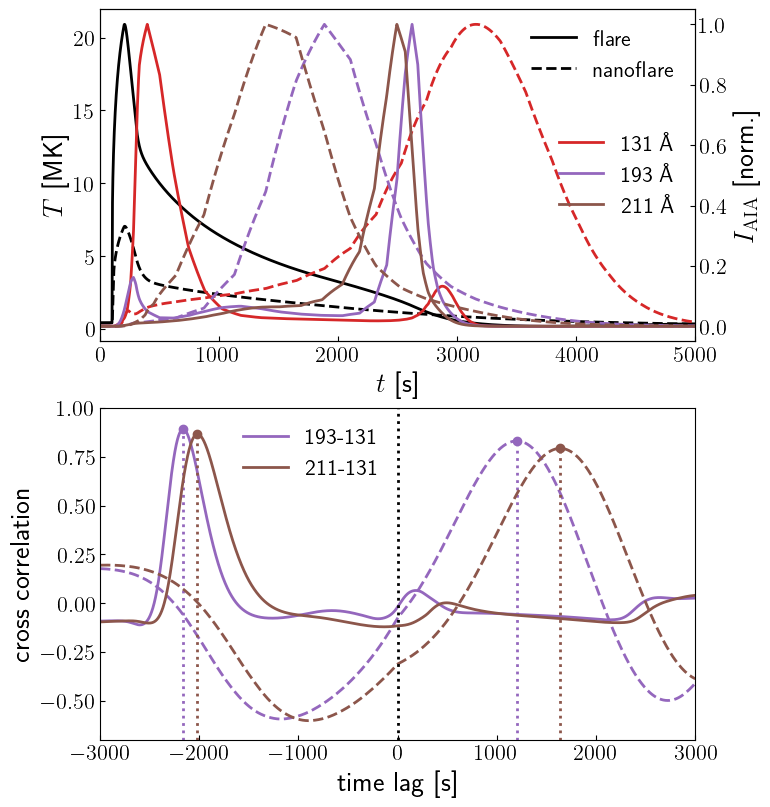

In [91]:
fig = plt.figure(
    figsize=(plt.rcParams['figure.figsize'][0]/2,plt.rcParams['figure.figsize'][1]),
)
# hydrodynamics
ax = fig.add_subplot(211)
ax.plot(results_flare.time, results_flare.electron_temperature.to('MK'),
        color='k', ls='-', label='flare')
ax.plot(results_nanoflare.time, results_nanoflare.electron_temperature.to('MK'),
        color='k', ls='--', label='nanoflare')
ax_intensity = ax.twinx()
for i,c in enumerate(['131', '193', '211']):
    intensity_flare = aia_kernel_quick(c, results_flare.electron_temperature, results_flare.density)
    ax_intensity.plot(results_flare.time,
                      intensity_flare/intensity_flare.max(),
                      color=f'C{i+3}', ls='-', label=f'{c} Å')
    intensity_nanoflare = aia_kernel_quick(c,
                                           results_nanoflare.electron_temperature, 
                                           results_nanoflare.density)
    ax_intensity.plot(results_nanoflare.time,
                      intensity_nanoflare/intensity_nanoflare.max(),
                      color=f'C{i+3}', ls='--')
ax.set_xlim(0,5000)
ax.set_ylabel(r'$T$ [MK]')
ax_intensity.set_ylabel(r'$I_\mathrm{AIA}$ [norm.]',)
ax.set_xlabel(r'$t$ [s]')
ax.legend(loc=1)
ax_intensity.legend(loc='center right',)
# time lag analysis
ax_tl = fig.add_subplot(212)
for i,(ca,cb) in enumerate([('193','131'), ('211','131')]):
    # flare
    cc_flare = compute_ebtel_aia_cross_correlation(results_flare, ca, cb)
    lags_flare = get_lags(results_flare.time)
    ax_tl.plot(lags_flare, cc_flare, color=f'C{4+i}', ls='-', label=f'{ca}-{cb}')
    ax_tl.plot(lags_flare[np.argmax(cc_flare)], cc_flare.max(), marker='o', color=f'C{4+i}')
    ax_tl.vlines(lags_flare[np.argmax(cc_flare)].value,
                 ymin=-1,
                 ymax=cc_flare.max().value,
                 ls=':',
                 color=f'C{4+i}')
    # nanoflare
    cc_nanoflare = compute_ebtel_aia_cross_correlation(results_nanoflare, ca, cb)
    lags_nanoflare = get_lags(results_nanoflare.time)
    ax_tl.plot(lags_nanoflare, cc_nanoflare, color=f'C{i+4}', ls='--')
    ax_tl.plot(lags_nanoflare[np.argmax(cc_nanoflare)], cc_nanoflare.max(),
               marker='o', color=f'C{4+i}')
    ax_tl.vlines(lags_nanoflare[np.argmax(cc_nanoflare)].value,
                 ymin=-1,
                 ymax=cc_nanoflare.max().value,
                 ls=':',
                 color=f'C{4+i}')
ax_tl.axvline(x=0, ls=':', color='k')
ax_tl.set_xlim(-3000,3000)
ax_tl.set_ylim(-0.7, 1)
ax_tl.set_xlabel('time lag [s]')
ax_tl.set_ylabel('cross correlation')
ax_tl.legend(loc='best', bbox_to_anchor=(0.5,1))
# save figure
fig.savefig(figure_dir / 'ebtel_timelag_simulation.pgf')

### Masking Figures

In [97]:
tl_131_flare_threshold = -2500
mask_pairs = (('211_131', '193_131'))
flare_masks_aia = [np.any([np.all([v.data < tl_131_flare_threshold, ~v.mask], axis=0) for k,v in tlma.items() if k in mask_pairs],axis=0)
                   for tlma in tl_maps_aia]
flare_masks_eis = [np.any([np.all([v.data < tl_131_flare_threshold, ~v.mask], axis=0) for k,v in tlma.items() if k in mask_pairs],axis=0)
                   for tlma in tl_maps_eis]

In [103]:
m_aia_cutout = sunpy.map.Map(data_dir / 'noaa_11944' / 'AIA' / 'level_2' / 'aia.lev2_euv_12s.2014-01-08T120001Z.94.image.fits')
m_aia_cutout.mask = flare_masks_aia[0]

In [136]:
width = plt.rcParams['figure.figsize'][0]/2
height = m_aia_cutout.data.shape[0]/m_aia_cutout.data.shape[1] * width
total_height = 3 * height

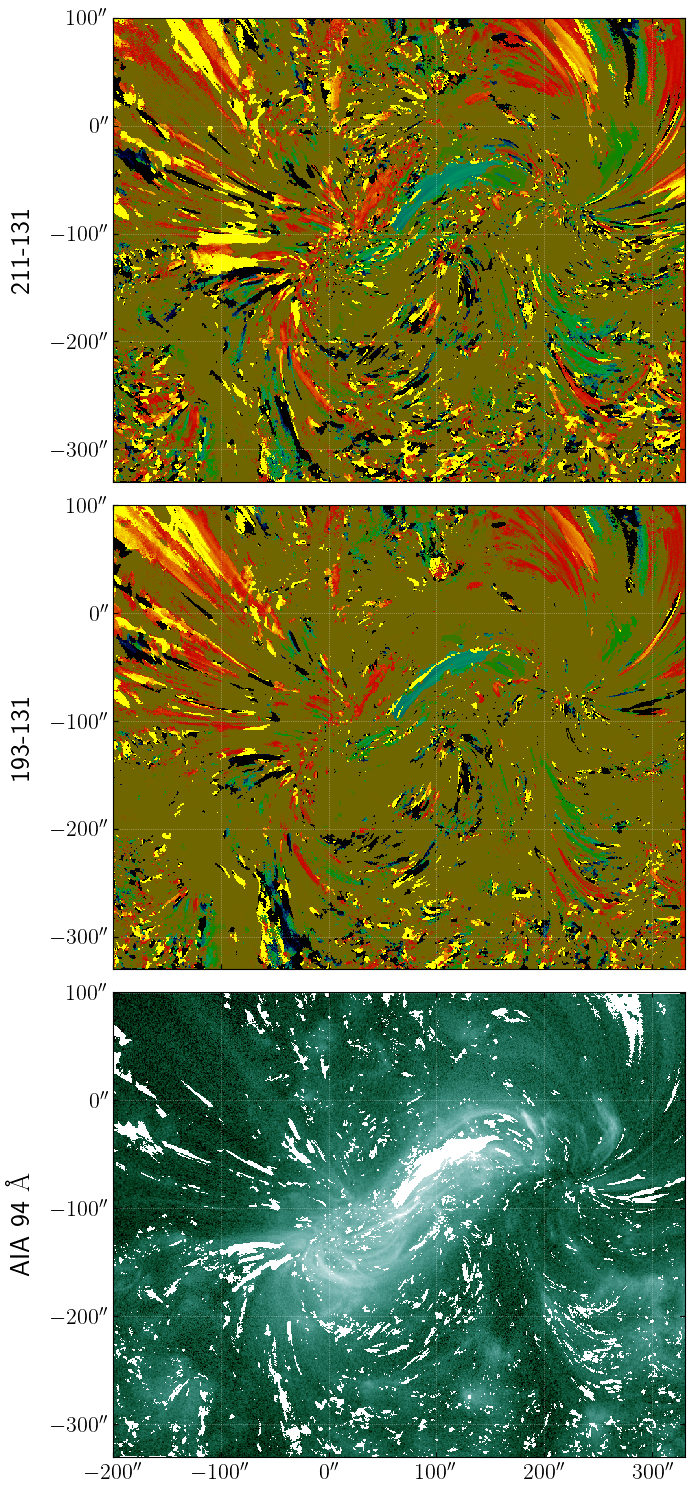

In [224]:
fig = plt.figure(figsize=(width, total_height))

for i,key in enumerate(mask_pairs):
    m_tl = copy.deepcopy(tl_maps_aia[0][key])
    m_tl.mask = None
    
    ax = fig.add_subplot(3,1,i+1,projection=m_tl)
    m_tl.plot(axes=ax,cmap='idl_bgry_004',vmin=-7200,vmax=7200, annotate=False)
    #ax.coords[1].set_auto_axislabel(False)
    ax.coords[0].set_auto_axislabel(False)
    ax.coords[1].set_axislabel('-'.join(key.split('_')))
   #ax.text(
   #    0.95,0.05,
   #    '-'.join(key.split('_')),
   #    transform=ax.transAxes,
   #    color='k',
   #    va='bottom',
   #    ha='right',
   #    fontsize=plt.rcParams['xtick.labelsize'],
   #    bbox={'boxstyle': 'round',
   #          'ec': 'w',
   #          'fc': 'w',
   #          'alpha': 0.75}
   #)
    ax.label_outer()
    ax.coords[0].set_ticklabel_visible(False)

ax = fig.add_subplot(313,projection=m_aia_cutout)
m_aia_cutout.plot(axes=ax,clip_interval=(1,99.999)*u.percent,annotate=False)
#ax.coords[1].set_auto_axislabel(False)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_axislabel(f'AIA {m_aia_cutout.wavelength.to_value(u.AA):.0f}' + r' $\mathrm{\AA}$');
#ax.text(
#    0.95,0.05,
#    f'AIA {m_aia_cutout.wavelength.to_value(u.AA):.0f}' + r' $\mathrm{\AA}$',
#    transform=ax.transAxes,
#    color='k',
#    va='bottom',
#    ha='right',
#    fontsize=plt.rcParams['xtick.labelsize'],
#    bbox={'boxstyle': 'round',
#          'ec': 'w',
#          'fc': 'w',
#          'alpha': 0.75}
#)
ax.label_outer()

plt.subplots_adjust(hspace=0.05)

fig.savefig(figure_dir / 'time_lag_mask.pgf')

## Emission Measure Slope Analysis

### Slope Maps

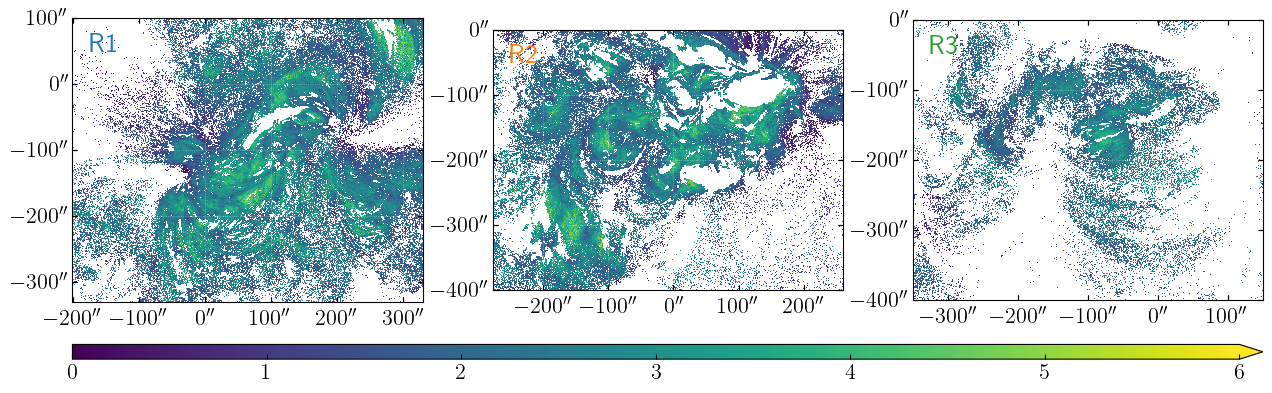

In [267]:
fig = plt.figure()
axes = []
for i,sm in enumerate(em_slopes_aia):
    _sm = copy.deepcopy(sm)
    _sm.mask = np.any([_sm.mask, flare_masks_aia[i]],axis=0)
    ax = fig.add_subplot(1,len(em_slopes_aia),i+1,projection=_sm)
    im = _sm.plot(axes=ax, vmin=0, vmax=6, cmap='viridis',annotate=False)
    ax.label_outer()
    ax.coords[0].set_auto_axislabel(False)
    ax.coords[1].set_auto_axislabel(False)
    ax.text(0.05, 0.95, f'R{i+1}',
            color=f'C{i}',
            va='top',
            ha='left',
            transform=ax.transAxes,
            fontsize=plt.rcParams['axes.titlesize'])
    axes.append(ax)
axes = np.array(axes)

pos_right = axes[-1].get_position().get_points()
pos_left = axes[0].get_position().get_points()
pad_y = 0.06
width = pos_right[1,0] - pos_left[0,0]
cax = fig.add_axes((pos_left[0,0],
                    pos_left[0,1]-pad_y,
                    width,
                    0.02*width))

fig.colorbar(im,
             cax=cax,
             orientation='horizontal',
             extend='max',
             extendfrac=0.02)

fig.savefig(figure_dir / 'em_slope_map.pgf')

### Slope Distributions

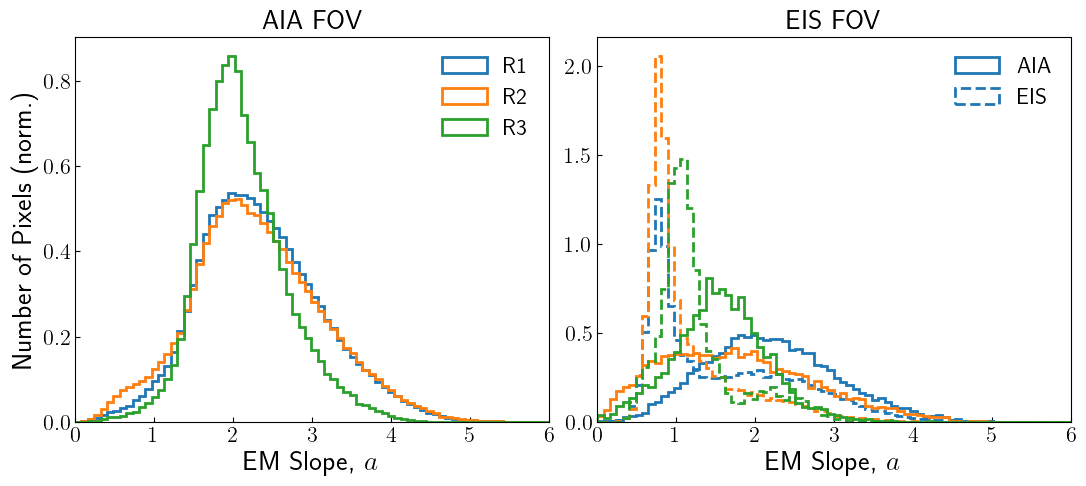

In [268]:
bins = np.linspace(0,8,100)
fig = plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*0.7,
                          plt.rcParams['figure.figsize'][1]/2),
                 layout='constrained')
ax = fig.add_subplot(121)
for i,sm in enumerate(em_slopes_aia):
    combined_mask = np.any([sm.mask, flare_masks_aia[i]],axis=0)
    ax.hist(sm.data[~combined_mask],
            bins=bins,
            density=True,
            histtype='step',
            label=f'R{i+1}')
ax.set_xlabel('EM Slope, $a$')
ax.set_ylabel('Number of Pixels (norm.)')
ax.legend()
ax.set_title('AIA FOV')

ax = fig.add_subplot(122,sharex=ax)
for i,(sme,sma) in enumerate(zip(em_slopes_eis,em_slopes_aia_eis_fov)):
    combined_mask = np.any([sme.mask, flare_masks_eis[i]],axis=0)
    ax.hist(sma.data[~combined_mask],
            bins=bins,
            density=True,
            histtype='step',
            ls='-',
            label='AIA' if i==0 else None,
            color=f'C{i}')
    ax.hist(sme.data[~combined_mask],
            bins=bins,
            density=True,
            histtype='step',
            ls='--',
            label='EIS' if i==0 else None,
            color=f'C{i}')
    combined_mask = np.any([sma.mask, flare_masks_eis[i]],axis=0)
ax.set_xlabel('EM Slope, $a$')
ax.legend()
ax.set_title('EIS FOV')
ax.set_xlim(0,6)
fig.savefig(figure_dir / 'emslope_distribution.pgf')

## Time Lag Analysis

In [225]:
selected_pairs = [
    '211_171',
    '193_171',
    '94_211',
    '335_193',
]

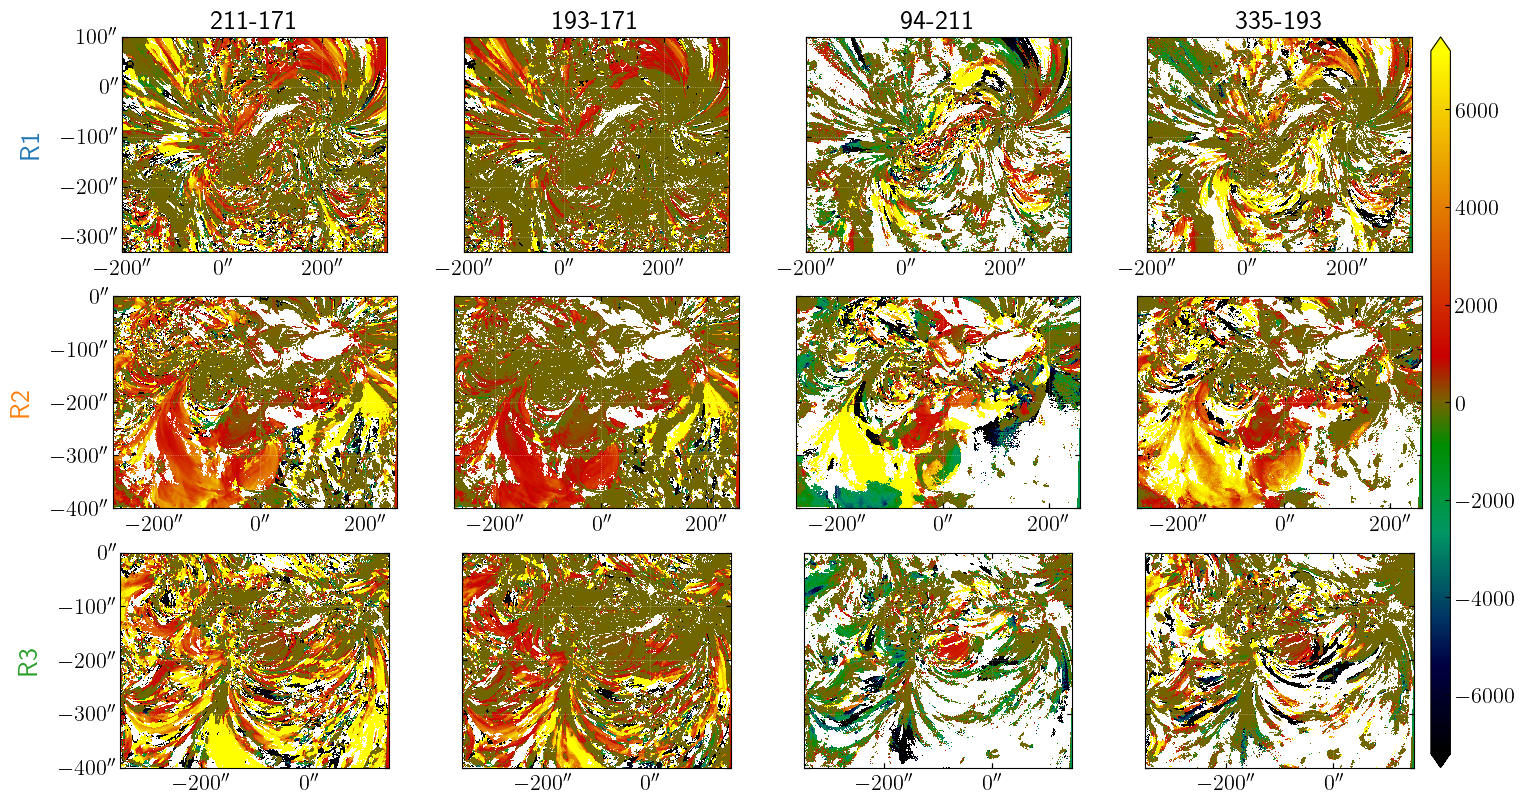

In [226]:
nr = len(tl_maps_aia)
nc = len(selected_pairs)
fig = plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*1.1,
                          plt.rcParams['figure.figsize'][1]))
axes = []
for i,sp in enumerate(selected_pairs):
    _axes = []
    for j,(tld,row) in enumerate(zip(tl_maps_aia,ar_table)):
        _m = copy.deepcopy(tld[sp])
        _m.mask = np.any([_m.mask, flare_masks_aia[j]], axis=0)
        ax = fig.add_subplot(nr, nc, j*nc+i+1, projection=_m)
        im = _m.plot(axes=ax, cmap='idl_bgry_004', vmin=-7200, vmax=7200, annotate=False)
        ax.label_outer()
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[0].set_ticks(number=4)
        if i > 0:
            ax.coords[1].set_ticklabel_visible(False)
        else:
            ax.coords[1].set_axislabel(f'R{j+1}', color=f'C{j}')
        if j == 0:
            ax.set_title('-'.join(sp.split('_')))
        #if j == nr-1:
        #    ax.coords[0].set_axislabel('HPC Longitude')
        _axes.append(ax)
    axes.append(_axes)
axes = np.array(axes).T

pos_lower = axes[-1,-1].get_position().get_points()
pos_upper = axes[0,-1].get_position().get_points()
pad_x = 0.01  # move the colorbar off the figure a bit
height = pos_upper[1,1] - pos_lower[0,1]
cax = fig.add_axes((pos_lower[1,0] + pad_x,
                    pos_lower[0,1],
                    0.015*height,
                    height))

fig.colorbar(im,
             cax=cax,
             orientation='vertical',
             extend='both',
             extendfrac=0.02)
fig.savefig(figure_dir / 'timelag_maps.pgf')

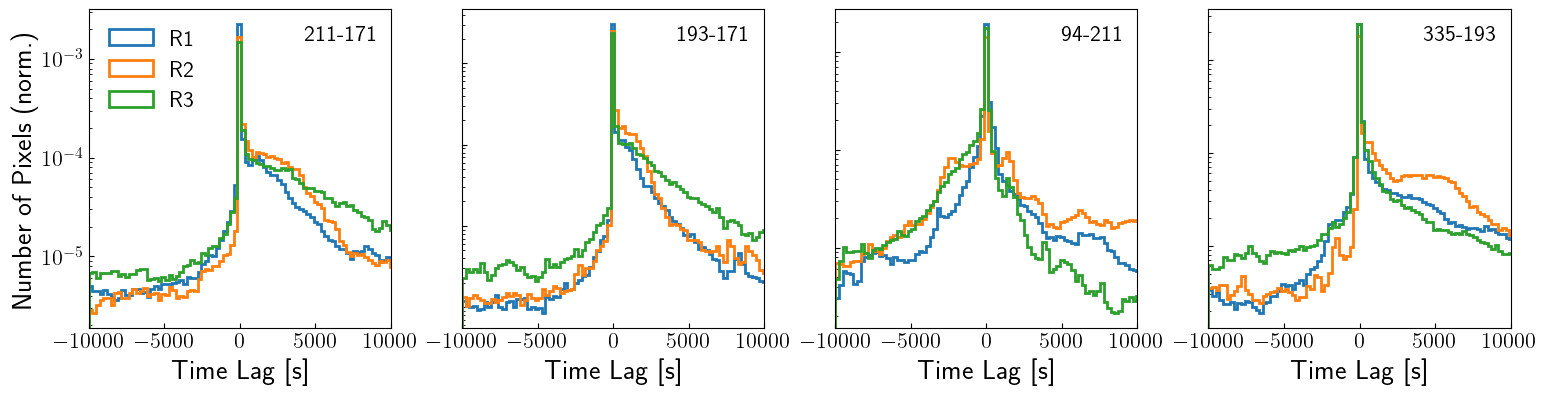

In [238]:
dt = 240
bin_lim = 1e4
bins = np.arange(-bin_lim,bin_lim+dt,dt)
fig,axes = plt.subplots(
    1,nc,
    figsize=(plt.rcParams['figure.figsize'][0],plt.rcParams['figure.figsize'][0]/4),
    layout='constrained',
    sharex=True,
    sharey=False
)
for j,(sp,ax) in enumerate(zip(selected_pairs,axes.flatten())):
    for i,(tld,row)in enumerate(zip(tl_maps_aia,ar_table)):
        _m = copy.deepcopy(tld[sp])
        ax.hist(_m.data[~np.any([_m.mask,flare_masks_aia[i]],axis=0)],
                histtype='step',
                density=True,
                log=True,
                label=f'R{i+1}',
                bins=bins)
    ax.text(
        0.95,0.95,
        '-'.join(sp.split('_')),
        transform=ax.transAxes,
        va='top',
        ha='right',
        fontsize=plt.rcParams['legend.fontsize'],
        color='k',
    )
    if j == 0:
        ax.legend(loc=2)
    ax.set_ylabel('Number of Pixels (norm.)')
    ax.set_xlabel('Time Lag [s]')
    ax.label_outer()
ax.set_xlim(-bin_lim,bin_lim)
fig.savefig(figure_dir / 'timelag_distribution.pgf')